In [1]:
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chisquare, geom

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font='serif')

threshold = 6

## Задание 1

Пусть $x_1 , . . . , x_n$ — выборка из геометрического распределения с параметром $p$. 
Воспользуйтесь критерием согласия $\chi^2$ для проверки $H_0 : p = p_0$.

### Пункт 1
Что делать, если некоторые из ожидаемых частот (подсчитываются в ходе применения критерия) маленькие?

Для применения критерия согласия $\chi^2$ существует требование $\forall j\, E_j = p_j n \geq 6$. 
Если это уловия не выополняется, то некоторые исходы необходимо объеденить.
Напишем функцию, которая разбивает исходы на правильные множества исходов.
Для написания подобной функции заметим, что исходы, которые необходимо оюъеденить, всегда идут подрят.
Последний исход всегда будет до бесконечности, а в остальных исходах будет указан полуинтервал вида $[a,b)$.

In [2]:
def outcome_sets(n, p):
    start_i, i, acc_p = 1, 1, 0

    outcomes = []
    while geom.sf(i, p) * n > threshold:
        acc_p += geom.pmf(i, p)
        i += 1
        if acc_p * n > threshold:
            outcomes.append((start_i, i))
            start_i = i
            acc_p = 0
    outcomes.append(start_i)
            
    return outcomes

**Пример множеств исходов** для $n=100$ и $p=0.3$.

In [3]:
outcome_sets(100, 0.3)

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 8), 8]

**Реализуем функцию**, которая применяет критерий с зададанным уровнем значимости.

In [4]:
def is_geom_with_p(ds, p, alpha):
    outcomes = outcome_sets(len(ds), p)
    
    tail = outcomes[-1] - 1
    expected = [geom.sf(tail, p) * len(ds)]
    observed = [(ds > tail).sum()]
    
    for left, right in outcomes[:-1]:
        expected.append(sum((geom.pmf(i, p) for i in range(left, right))) * len(ds))
        observed.append(((ds >= left) & (ds < right)).sum())
    
    _, p_val = chisquare(observed, expected)
    return p_val > alpha

Проверим **корректность построенного критерия**

In [5]:
tries = 1000
alpha = 0.05
n = 420
p = 0.3

results = [is_geom_with_p(geom.rvs(p, size=n), p, alpha) for _ in range(tries)]
np.mean(results)

0.943

### Пункт 2
Есть ли зависимость мощности от $p_1$ при выборе простой $H_1 : p = p_1$? Продемонстрируйте это с помощью моделирования;

**Да, зависимость есть.**
Тем выше мощность, чем больше $|p_1 - p_0|$, продемострируем это:

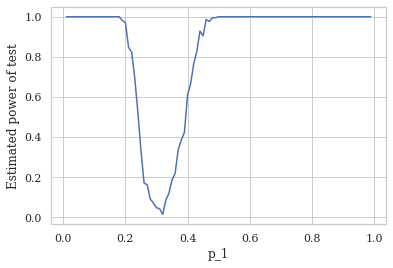

In [6]:
p_0 = 0.3
n = 100
alpha = 0.05
tries = 210
p_1_min, p_1_max, p_1_step = 0.01, 1, 0.01

ps_1 = np.arange(p_1_min, p_1_max, p_1_step)
power_of_test = []   
for p_1 in ps_1:
    results = [is_geom_with_p(geom.rvs(p_1, size=n), p_0, alpha) for _ in range(tries)]
    power_of_test.append(1 - np.mean(results))
    
plt.plot(ps_1, power_of_test)
plt.xticks(label=np.round(ps_1,2))
plt.xlabel('p_1')
plt.ylabel('Estimated power of test')
plt.show()